In [129]:
import numpy as np
from matplotlib import pyplot as plt
import math
from dataclasses import dataclass
from functools import cache
from typing import Optional, List
from sortedcontainers import SortedDict

In [130]:
class Particle:
    """
    A particle in a one-dimensional electrostatic cold stream plasma.

    Attributes:
    -----------
    id : int
        Label to preserve order of particles
    alpha : float
        The Lagrangian coordinate of the particle, ranging from 1:N
    x : float
        The position of the particle in the domain [0,1).
    v : float
        The velocity of the particle.
    """
    id: int
    alpha: float
    x: float
    v: float
    a: float
    active: bool
    pos_hist: list
    vel_hist: list
    periods_traversed : int = 0
    period_hist: list 

    def __init__(self, id_in: int, N: int, epsilon: float):
        """
        Initialize the particle with a given position and set all other attributes to zero.
        
        Parameters:
        -----------
        id_in : int
            The ID of the particle.
        N_in : int
            The total number of particles.
        epsilon : magnitude of disruption
        """
        self.id = id_in
        self.active = True if self.id % 2 == 0 else False
        self.alpha = (self.id - 1) / (2*N) 
        self.x = self.alpha + epsilon*math.sin(2* math.pi * self.alpha)
        self.v = 0.0
        self.a = 0.0
        self.pos_hist = [self.x]
        self.vel_hist = [self.v]
        self.acc_hist = [0]
        self.period_hist = [0]

        

    def __lt__(self, other):
        """
        Compare two particles with respect to their Lagrangian Coordinates

        Parameters:
        -----------
        other : Particle
            The other particle that the current one will be compared to

        """
        return self.alpha < other.alpha


    def update_position(self, dt):
        """
        Update the position of the particle based on its current velocity and the
        elapsed time using Euler's Method.
        
        Args:
            dt (float): The elapsed time in seconds.
        
        Returns:
            None
        """
        self.x = self.x + self.vel_hist[-2] * dt
        if self.x > 1: self.periods_traversed += 1
        if self.x < 0: self.periods_traversed -= 1
        self.x = self.x % 1
        self.pos_hist.append(self.x)
        self.period_hist.append(self.periods_traversed)


    def update_velocity(self, dt):
        """
        Update the velocity of the particle based on the given acceleration and
        the elapsed time using Euler's Method.
        
        Args:
            acceleration (float): The acceleration of the particle.
            dt (float): The elapsed time in seconds.
        
        Returns:
            None
        """
        self.v += self.a * dt
        self.vel_hist.append(self.v)

    def update_acceleration(self, acceleration):
        """
        Update the acceleration of the particle based on the given acceleration
        function.
        
        Args:
            acceleration (float): The acceleration of the particle.
        
        Returns:
            None
        """
        self.a = acceleration(self)
        self.acc_hist.append(self.a)



In [131]:
class Plasma_Evolver:


    N: int
    dt: float
    epsilon: float
    delta: float
    ion_density: float = 1
    plasma : SortedDict
    t: float = 0
    kernel: callable
    green: callable
    
    def __init__(self, N_in: int, dt_in: float, kernel_in: callable, greens_in: callable,
                  epsilon_in: float = 0.05, delta_in: float = 0.002):
        """
        Initializes Plasma_Evolver class, setting parameters and initializing the plasma in
        a Sorted Dict

        Args:
        - N_in (int): The number of particles to generate.
        - dt_in (float): Simulation timestep
        - epsilon (float): Magnitude of the perturbation. Defaults to 0.05.

        """
        self.N = N_in
        self.dt = dt_in
        self.kernel = kernel_in
        self.greens = greens_in
        self.epsilon = epsilon_in
        self.delta = delta_in
        self.plasma = SortedDict()
        self.weights = SortedDict()

        for i in range(1, 2*self.N+1):
            p = Particle(i, self.N, epsilon=self.epsilon)
            self.plasma[p.alpha] = p
        
        for p in self.plasma.values():
            self.weights[p.alpha] = self.get_w(p)

        
    
    def get_w(self, p: Particle) -> float:

        index = self.plasma.bisect_left(p.alpha)
        prev_index = index - 1

        if prev_index >= 0:
            return p.alpha - list(self.plasma.values())[prev_index].alpha
        else:
            return 1 - (list(self.plasma.values())[-1].alpha - p.alpha)
        


    def calc_acceleration(self, p: Particle) -> float:

        """
        Calculates the acceleration on a given particle due to rest of the stream
        without regularization

        Returns:
            float: acceleration
        """

        sum_k = 0
        sum_x = 0

        for q in self.plasma.values():
            if not q.active: continue
            w = self.weights[q.alpha]
            sum_k += self.kernel(p.x, q.x, self.delta) * w
            sum_x += q.x * w

        first = - sum_k
        second = self.ion_density*(p.x - 0.5)
        third = (sum_x - 0.5)
        new_acc = first + second + third

        return new_acc
    
    def calc_acceleration_reg(self, p: Particle) -> float:

        """
        Calculates the acceleration on a given particle due to rest of the stream
        with regularization

        Returns:
            float: acceleration
        """

        sum_k = 0
        sum_rho = 0
        sum_a = 0

        for q in self.plasma.values():
            if not q.active: continue
            w = self.weights[q.alpha]
            sum_k += self.kernel(p.x, q.x, self.delta) * w
            sum_rho += (self.kernel(1, q.x, self.delta) - self.kernel(0, q.x, self.delta)) * w
            sum_a += (self.greens(1, q.x, self.delta) - self.greens(0, q.x, self.delta)) * w


        return - sum_k + sum_rho*(p.x - 0.5) - (sum_a)
    
    
    def evolve_plasma(self, time: float):
        """
        Evolves the plasma for the given amount of time

        Args:
            time (float): Time to evolve plasma over
        """

        self.t += time

        for i in range(int(time / self.dt)):
            for p in self.plasma.values():
                if self.delta == 0: p.update_acceleration(self.calc_acceleration)
                else: p.update_acceleration(self.calc_acceleration_reg)
            for p in self.plasma.values():
                p.update_velocity(self.dt)
                p.update_position(self.dt)
                

    def plot_particles(self,times: tuple = (-1,), periods: int = 1, zoom: bool = False):
        """
        Plots particles stored in a sorted dictionary in phase space as points where
        the x-coordinate is position and the y-coordinate is velocity, and lines that 
        connect neighboring particles on the sorted dictionary.
        
        Args:
        - zoom (bool): boolean to zoom in into the center.
        
        Returns:
        - None
        """

        cmap = plt.get_cmap('tab10')

        colors = [cmap(i) for i in range(periods)]

        size = (5*periods,2*len(times))

        if zoom:
            times = (times[-1],)
            periods = 1
            size = (8,6)

        fig, axs = plt.subplots(len(times), 1, figsize=size, dpi=200)
        

        # Convert axs to an iterable if it contains a single subplot
        axs = np.atleast_1d(axs)

        fig.suptitle(r'Particle Phase Space ($N = {}$, $\delta = {}$)'.format(self.N, self.delta))
        #fig.text(0.5, 0.01, 'Position', ha='center')
        #fig.text(0.04, 0.5, 'Velocity', va='center', rotation='vertical')
        


        for num, t in enumerate(times):

            if t == -1 or t > self.t:
                t = self.t
            
            index = int(t / self.dt)
            
            # Extract positions and velocities of particles
            positions = np.array([(p.pos_hist[index] + p.period_hist[index]) for p in self.plasma.values()])
            velocities = np.array([p.vel_hist[index] for p in self.plasma.values()])

            # Plot particles as points in phase space
            axs[num].set_xlim((0,periods))
            axs[num].set_ylim((-0.5,0.5))

            # Add lines connecting neighboring particles on the sorted dictionary
            for j in range(periods):
                axs[num].scatter(positions + j, velocities, s=2)
                axs[num].set_title("t = " + str(t))
                if zoom: axs[num].hlines(y=0, xmin=0, xmax=periods, linewidth = 1, color = 'b', linestyle = '--')
                for i, (k, p) in enumerate(self.plasma.items()):
                    if i == 0:
                        if j != 0:
                            prev_p = list(self.plasma.values())[-1]
                            print([prev_p.pos_hist[index] + j - 1, p.pos_hist[index] + j ])
                            #axs[num].plot([prev_p.pos_hist[index] + j - 1, p.pos_hist[index] + j ], 
                            #        [prev_p.vel_hist[index], p.vel_hist[index]], color=colors[j], alpha=0.3)
                        continue
                    prev_p = list(self.plasma.values())[i-1]
                    axs[num].plot([prev_p.pos_hist[index] + j + prev_p.period_hist[index], 
                                   p.pos_hist[index] + j + p.period_hist[index]], 
                                [prev_p.vel_hist[index], p.vel_hist[index]], color=colors[j], alpha=0.3)

            if zoom:
                axs[num].set_xlim((0.45, 0.55))
                axs[num].set_ylim((-0.1, 0.1))
                
        fig.tight_layout()


            
        

In [132]:
def k(p1: float, p2: float, delta: float) -> float:
    diff = p1 - p2
    if (diff > 0):
        return 0.5 
    elif diff < 0:
        return -0.5
    return 0

def gd(p1: float, p2: float, delta: float) -> float:
    return -0.5 * math.sqrt((p1 - p2)**2 + delta**2)

def kd(p1: float, p2: float, delta: float) -> float:
    diff = p1 - p2
    if diff != 0: return 0.5 * diff / math.sqrt(diff**2 + delta**2)
    return 0


[0.9934294620460937, 1.0]
[0.9929815255035497, 2.0]
[0.9914084920370185, 2.0]
[0.9879227036348914, 2.0]
[0.9807469625082983, 2.0]
[0.9661858613808012, 2.0]


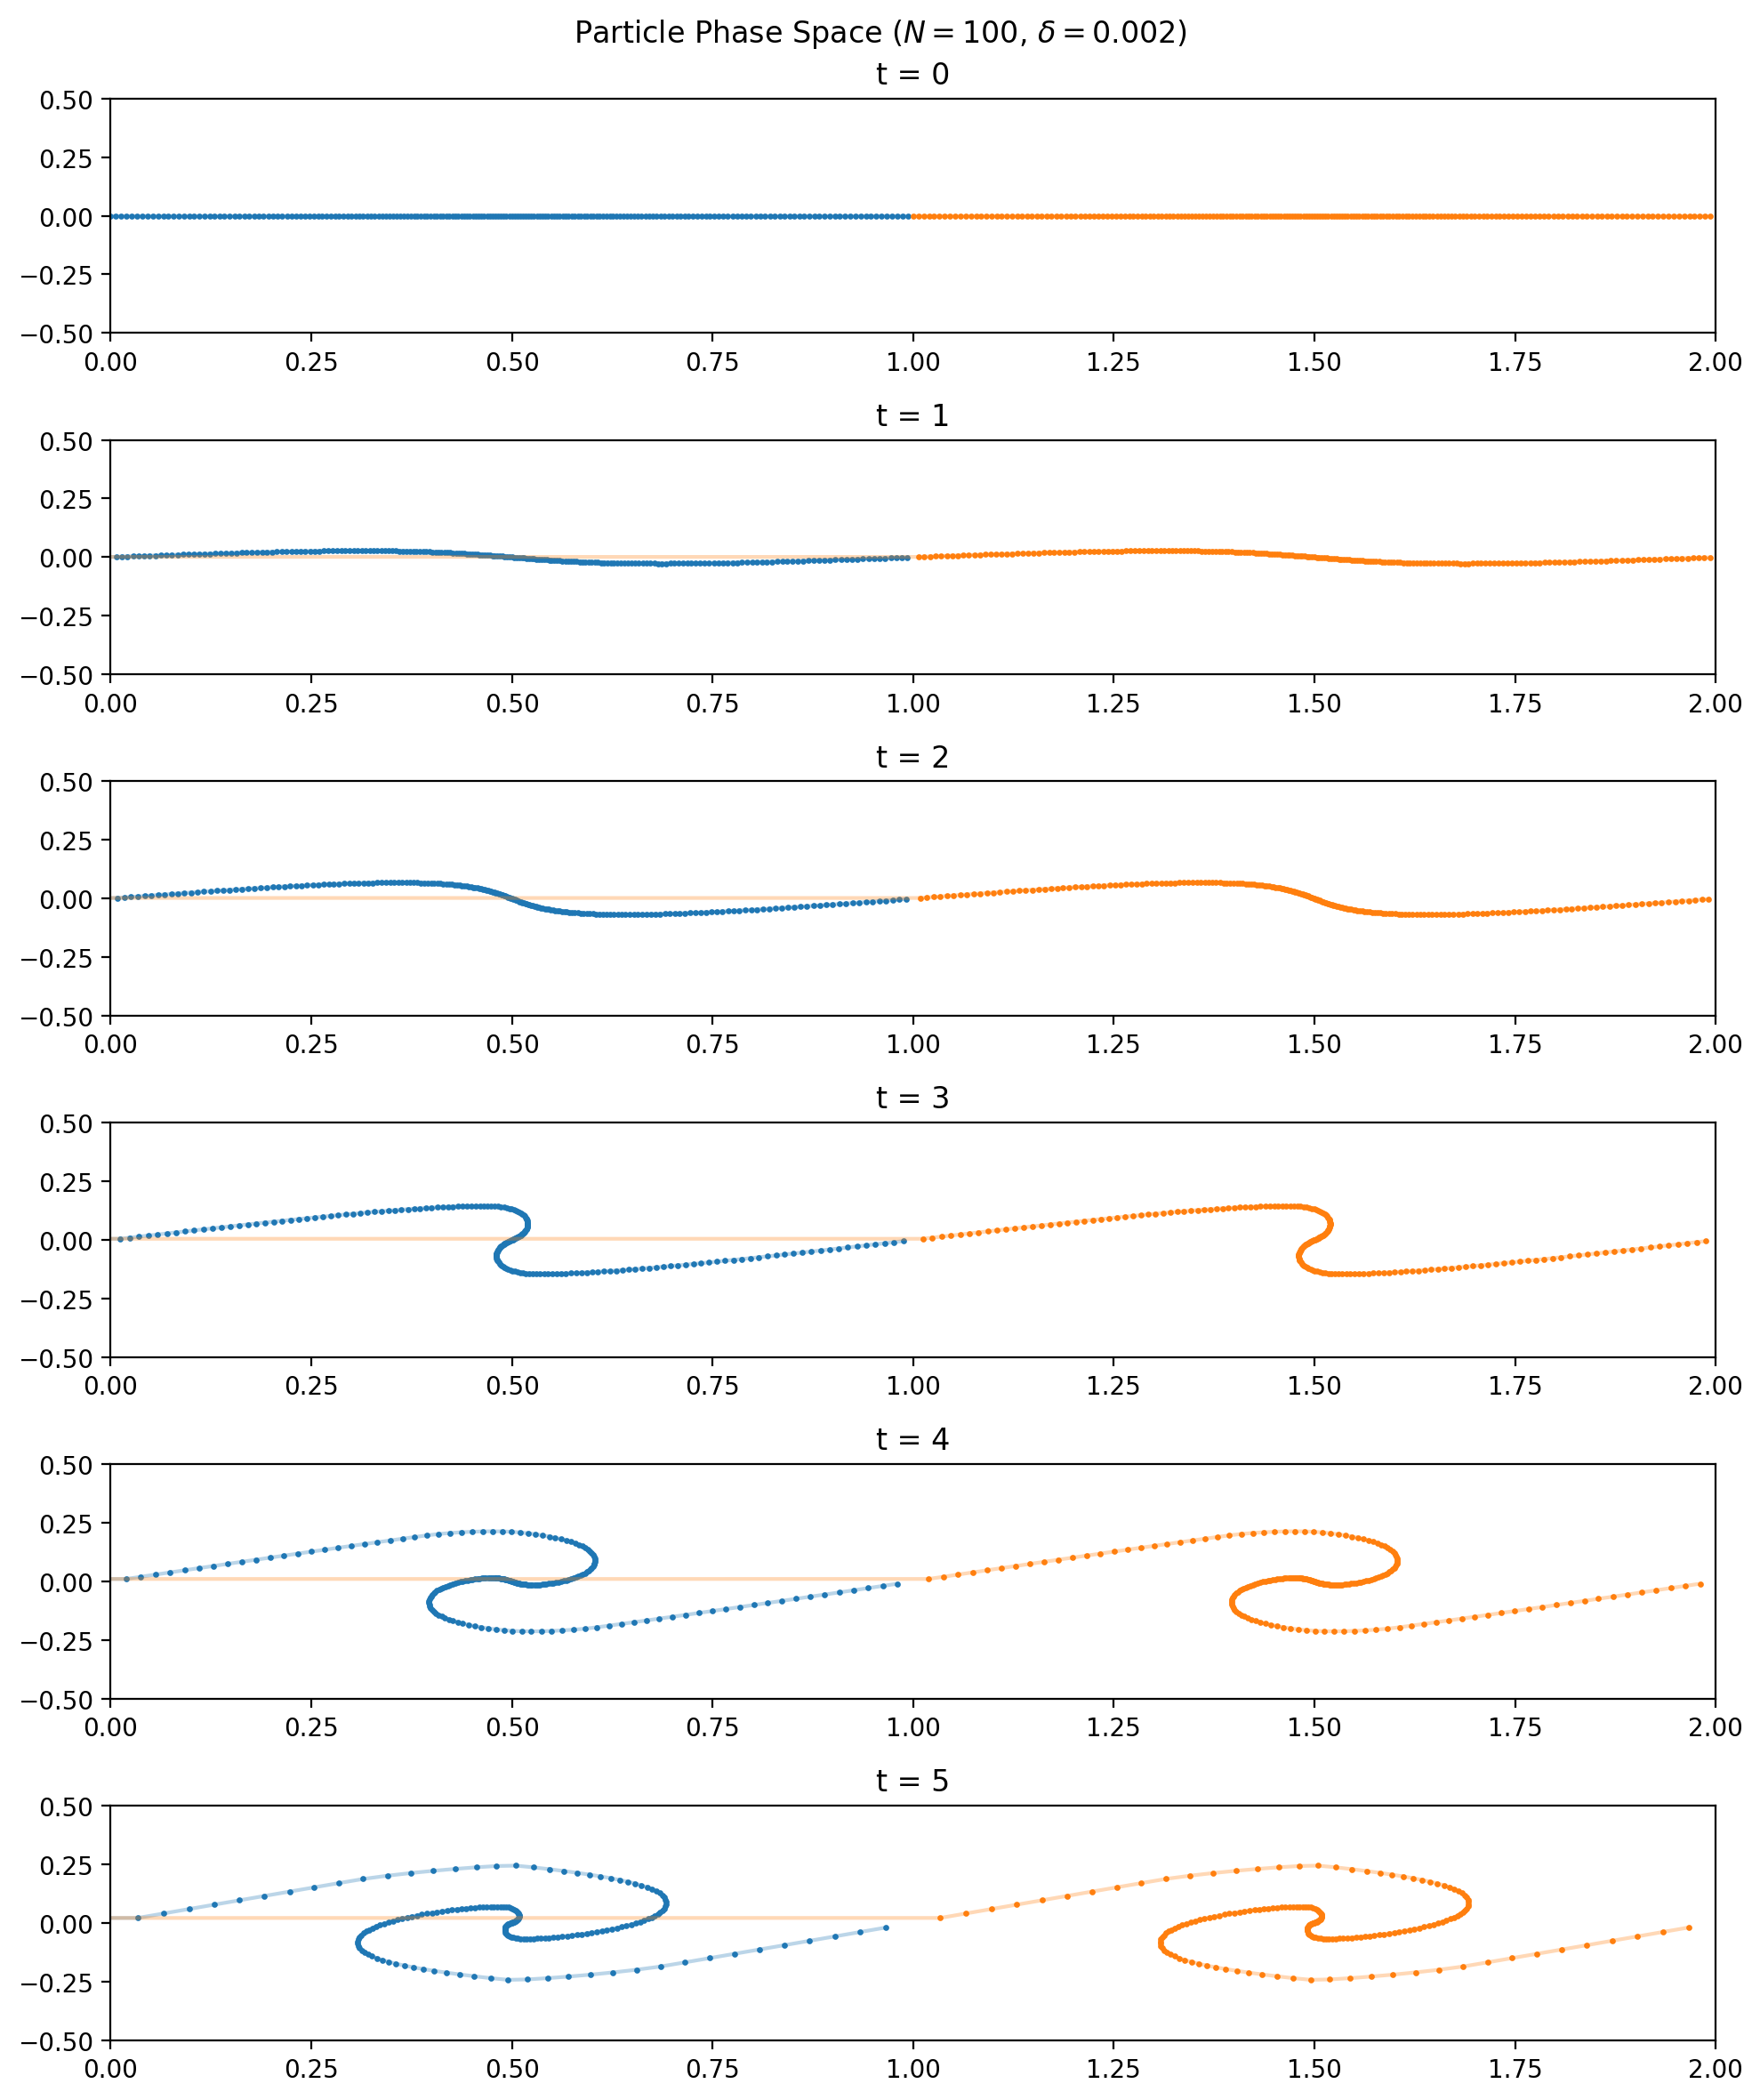

In [133]:
driver = Plasma_Evolver(100, 0.01, kd, gd, delta_in=0.002)


tmax = 5
driver.evolve_plasma(tmax)
driver.plot_particles([i for i in range(0,tmax + 1,1)], periods=2)
#driver.plot_particles(zoom=True)